In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

os.chdir('/Users/dbm829/Documents/work/Projects/GitHub/omicsDGD/')

## functions

In [2]:
import torch

def compute_error_per_sample(target, output, reduction_type='ms'):
    '''compute sample-wise error
    It can be of type `ms` (mean squared) or `ma` (mean absolute)
    '''
    error = target - output
    if reduction_type == 'ms':
        return torch.mean(error**2, dim=-1)
    elif reduction_type == 'ma':
        return torch.mean(torch.abs(error), dim=-1)
    else:
        raise ValueError('invalid reduction type given. Can only be `ms` or `ma`.')

In [3]:
def binary_output_scores(target, output, scaling_factor, switch, threshold, batch_size=5000, feature_indices=None):
    '''returns FPR, FNR, balanced accuracy, LR+ and LR-'''
    tp, fp, tn, fn = classify_binary_output(target, output, scaling_factor, switch, threshold, batch_size, feature_indices)
    tp = tp.sum()
    fp = fp.sum()
    tn = tn.sum()
    fn = fn.sum()
    tpr = tp / (tp + fn) # sensitivity
    tnr = tn / (tn + fp) # specificity
    fpr = 1 - tnr
    fnr = 1 - tpr
    balanced_accuracy = (tpr + tnr) / 2
    positive_likelihood_ratio = tpr/fpr
    negative_likelihood_ratio = fnr/tnr

    return tpr.item(), tnr.item(), balanced_accuracy.item(), positive_likelihood_ratio.item(), negative_likelihood_ratio.item()

def classify_binary_output(target, output, scaling_factor, switch, threshold, batch_size=5000, feature_indices=None):
    '''calculating true positives, false positives, true negatives and false negatives'''
    print('classifying binary output')
    
    n_samples = target.shape[0]
    true_positives = torch.zeros((n_samples))
    false_positives = torch.zeros((n_samples))
    true_negatives = torch.zeros((n_samples))
    false_negatives = torch.zeros((n_samples))
    
    for i in range(int(n_samples/batch_size)+1):
        print(round(i/(int(n_samples/batch_size))*100),'%')
        start = i*batch_size
        end = min((i+1)*batch_size,n_samples)
        indices = np.arange(start,end,1)
        x_accessibility = binarize(torch.Tensor(target[indices,:])).int()
        y_accessibility = output[indices,:]
        if type(y_accessibility) is not torch.Tensor:
            if type(y_accessibility) == pd.core.frame.DataFrame:
                y_accessibility = torch.from_numpy(y_accessibility.values)
                y_accessibility = y_accessibility.detach().cpu()
        else:
            y_accessibility = y_accessibility.detach().cpu()*scaling_factor[indices]
        y_accessibility = binarize(y_accessibility, threshold).int()
        if feature_indices is not None:
            x_accessibility = x_accessibility[:,feature_indices]
            y_accessibility = y_accessibility[:,feature_indices]
        p = (x_accessibility == 1)
        pp = (y_accessibility == 1)
        true_positives[indices] = torch.logical_and(p,pp).sum(-1).float()
        true_negatives[indices] = torch.logical_and(~p,~pp).sum(-1).float()
        false_positives[indices] = (y_accessibility > x_accessibility).sum(-1).float()
        false_negatives[indices] = (y_accessibility < x_accessibility).sum(-1).float()
    
    return true_positives, false_positives, true_negatives, false_negatives

def binarize(x, threshold=0.5):
    x[x >= threshold] = 1
    x[x < threshold] = 0
    return x

# recalculate all losses

## random seed 0

In [ ]:
# read the test and reconstructions from the saved files
test_gex = np.load('results/analysis/performance_evaluation/reconstruction/mouse_test_counts_gex.npy')
recon_gex = np.load('results/analysis/performance_evaluation/reconstruction/mouse_gast_l20_h2-2_rs0_test_recon_gex.npy')

In [13]:
# read the test and reconstructions from the saved files
test_atac = np.load('results/analysis/performance_evaluation/reconstruction/test_counts_atac.npy')
recon_atac = np.load('results/analysis/performance_evaluation/reconstruction/mouse_gast_l20_h2-2_rs0_test_recon_atac.npy')

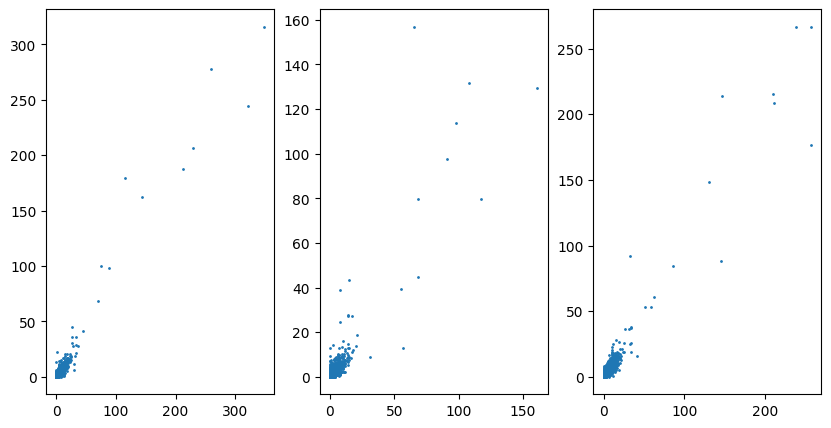

In [3]:
# plot the first three cells
fig, ax = plt.subplots(1,3, figsize=(10,5))
for i in range(3):
    ax[i].scatter(test_gex[i,:], recon_gex[i,:]*test_gex[i,:].sum(), s=1)
plt.show()

In [10]:
# compute RMSE and MAE here

import torch
n_samples = test_gex.shape[0]
errors = compute_error_per_sample(torch.tensor(test_gex), torch.tensor(recon_gex)*torch.tensor(test_gex).sum(axis=1).unsqueeze(1), reduction_type='ms')
out_error = torch.sqrt(torch.mean(errors))
print('RMSE: ', out_error.item())

errors = compute_error_per_sample(torch.tensor(test_gex), torch.tensor(recon_gex)*torch.tensor(test_gex).sum(axis=1).unsqueeze(1), reduction_type='ma')
out_error = torch.sqrt(torch.mean(errors))
print('MAE: ', out_error.item())


RMSE:  1.9660552740097046
MAE:  0.8364396691322327


In [20]:
# compute loss for ATAC data

threshold = 0.2
tpr, tnr, balanced_accuracy, positive_likelihood_ratio, negative_likelihood_ratio = binary_output_scores(test_atac, torch.tensor(recon_atac), torch.tensor(test_atac).sum(1).unsqueeze(1), test_gex.shape[1], threshold)
df_temp = pd.DataFrame({
    'TPR (atac)': tpr,
    'TNR (atac)': tnr,
    'balanced accuracy': balanced_accuracy,
    'LR+': positive_likelihood_ratio,
    'LR-': negative_likelihood_ratio,
    'binary_threshold': threshold
}, index=[0])
print(df_temp)

classifying binary output
0 %
100 %
   TPR (atac)  TNR (atac)  balanced accuracy       LR+       LR-  \
0    0.820398    0.644441           0.732419  2.307346  0.278694   

   binary_threshold  
0               0.2  


## Random seed 37

In [6]:
test_gex = np.load('results/analysis/performance_evaluation/reconstruction/mouse_test_counts_gex.npy')
recon_gex = np.load('results/analysis/performance_evaluation/reconstruction/mouse_gast_l20_h2-2_rs37_test_recon_gex.npy')
test_atac = np.load('results/analysis/performance_evaluation/reconstruction/test_counts_atac.npy')
recon_atac = np.load('results/analysis/performance_evaluation/reconstruction/mouse_gast_l20_h2-2_rs37_test_recon_atac.npy')

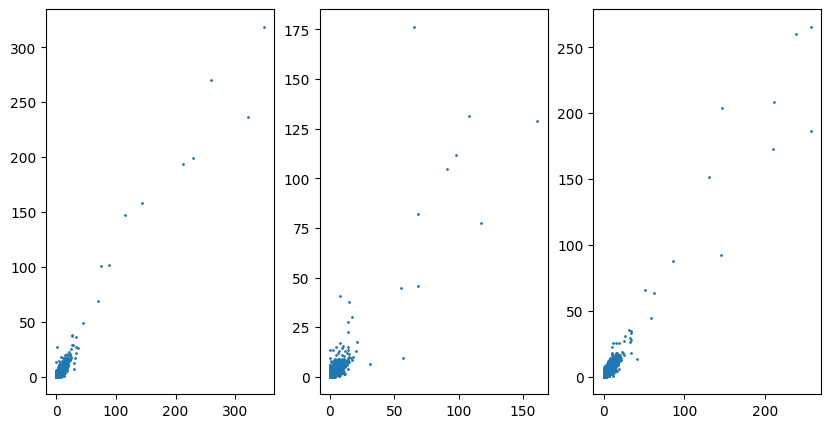

In [7]:
# plot the first three cells
fig, ax = plt.subplots(1,3, figsize=(10,5))
for i in range(3):
    ax[i].scatter(test_gex[i,:], recon_gex[i,:]*test_gex[i,:].sum(), s=1)
plt.show()

In [8]:
# compute RMSE and MAE here

import torch
n_samples = test_gex.shape[0]
errors = compute_error_per_sample(torch.tensor(test_gex), torch.tensor(recon_gex)*torch.tensor(test_gex).sum(axis=1).unsqueeze(1), reduction_type='ms')
out_error = torch.sqrt(torch.mean(errors))
print('RMSE: ', out_error.item())

errors = compute_error_per_sample(torch.tensor(test_gex), torch.tensor(recon_gex)*torch.tensor(test_gex).sum(axis=1).unsqueeze(1), reduction_type='ma')
out_error = torch.sqrt(torch.mean(errors))
print('MAE: ', out_error.item())

RMSE:  1.9834249019622803
MAE:  0.8358525633811951


In [9]:
# compute loss for ATAC data

threshold = 0.2
tpr, tnr, balanced_accuracy, positive_likelihood_ratio, negative_likelihood_ratio = binary_output_scores(test_atac, torch.tensor(recon_atac), torch.tensor(test_atac).sum(1).unsqueeze(1), test_gex.shape[1], threshold)
df_temp = pd.DataFrame({
    'TPR (atac)': tpr,
    'TNR (atac)': tnr,
    'balanced accuracy': balanced_accuracy,
    'LR+': positive_likelihood_ratio,
    'LR-': negative_likelihood_ratio,
    'binary_threshold': threshold
}, index=[0])
print(df_temp)

classifying binary output
0 %
100 %
   TPR (atac)  TNR (atac)  balanced accuracy       LR+       LR-  \
0    0.820339    0.644587           0.732463  2.308133  0.278722   

   binary_threshold  
0               0.2  


## Random seed 8790

In [6]:
test_gex = np.load('results/analysis/performance_evaluation/reconstruction/mouse_test_counts_gex.npy')
recon_gex = np.load('results/analysis/performance_evaluation/reconstruction/mouse_gast_l20_h2-2_rs8790_test_recon_gex.npy')
test_atac = np.load('results/analysis/performance_evaluation/reconstruction/test_counts_atac.npy')
recon_atac = np.load('results/analysis/performance_evaluation/reconstruction/mouse_gast_l20_h2-2_rs8790_test_recon_atac.npy')

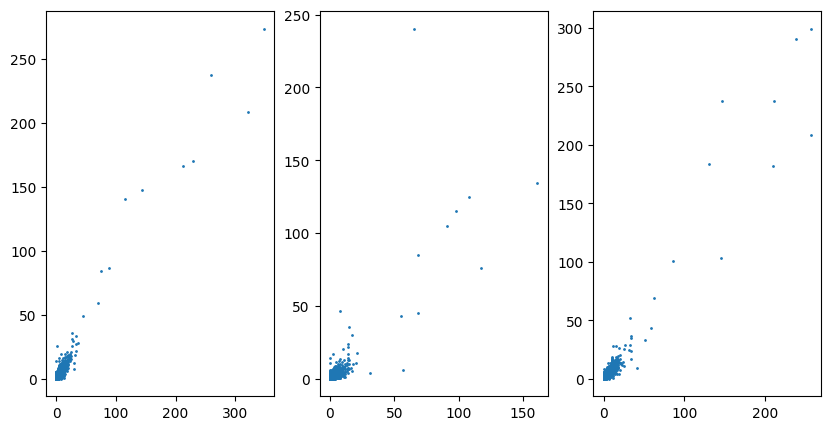

In [7]:
# plot the first three cells
fig, ax = plt.subplots(1,3, figsize=(10,5))
for i in range(3):
    ax[i].scatter(test_gex[i,:], recon_gex[i,:]*test_gex[i,:].sum(), s=1)
plt.show()

In [8]:
# compute RMSE and MAE here

import torch
n_samples = test_gex.shape[0]
errors = compute_error_per_sample(torch.tensor(test_gex), torch.tensor(recon_gex)*torch.tensor(test_gex).sum(axis=1).unsqueeze(1), reduction_type='ms')
out_error = torch.sqrt(torch.mean(errors))
print('RMSE: ', out_error.item())

errors = compute_error_per_sample(torch.tensor(test_gex), torch.tensor(recon_gex)*torch.tensor(test_gex).sum(axis=1).unsqueeze(1), reduction_type='ma')
out_error = torch.sqrt(torch.mean(errors))
print('MAE: ', out_error.item())

RMSE:  2.037562131881714
MAE:  0.8390697836875916


In [9]:
# compute loss for ATAC data

threshold = 0.2
tpr, tnr, balanced_accuracy, positive_likelihood_ratio, negative_likelihood_ratio = binary_output_scores(test_atac, torch.tensor(recon_atac), torch.tensor(test_atac).sum(1).unsqueeze(1), test_gex.shape[1], threshold)
df_temp = pd.DataFrame({
    'TPR (atac)': tpr,
    'TNR (atac)': tnr,
    'balanced accuracy': balanced_accuracy,
    'LR+': positive_likelihood_ratio,
    'LR-': negative_likelihood_ratio,
    'binary_threshold': threshold
}, index=[0])
print(df_temp)

classifying binary output
0 %
100 %
   TPR (atac)  TNR (atac)  balanced accuracy       LR+       LR-  \
0    0.820196    0.643944            0.73207  2.303561  0.279223   

   binary_threshold  
0               0.2  
